In [1]:
import pandas as pd

# read csv review tokopedia
df = pd.read_csv('/content/drive/MyDrive/nlp_project/review_tokped.csv')
df.head()

,Review,Rating,Sentiment
0,enak kuacinya,5,positive
1,pengiriman cepat packing bagus sesuai pesanan ...,5,positive
2,pengemasan luar biasa baik untuk rasa menurut ...,4,negative
3,terimakasih min,5,neutral
4,udah order untuk kesekian kali jos,5,neutral


In [2]:
# melihat jumlah data
df.shape

(4060, 3)

In [3]:
# Menghapus kolom Rating
df = df.drop(columns='Rating')
df.head()

,Review,Sentiment
0,enak kuacinya,positive
1,pengiriman cepat packing bagus sesuai pesanan ...,positive
2,pengemasan luar biasa baik untuk rasa menurut ...,negative
3,terimakasih min,neutral
4,udah order untuk kesekian kali jos,neutral


In [4]:
# Melakukan one-hot-encoding pada kolom Sentiment
df_baru = pd.get_dummies(df.Sentiment)
df_baru.head()

,negative,neutral,positive
0,0,0,1
1,0,0,1
2,1,0,0
3,0,1,0
4,0,1,0


In [5]:
# Menggabungkan dataframe df dengan df_baru hasil one-hot-encoding
df_baru = pd.concat([df, df_baru], axis=1)
df_baru.head()

,Review,Sentiment,negative,neutral,positive
0,enak kuacinya,positive,0,0,1
1,pengiriman cepat packing bagus sesuai pesanan ...,positive,0,0,1
2,pengemasan luar biasa baik untuk rasa menurut ...,negative,1,0,0
3,terimakasih min,neutral,0,1,0
4,udah order untuk kesekian kali jos,neutral,0,1,0


In [6]:
# Menghapus kolom Sentiment
df_baru = df_baru.drop(columns='Sentiment')
df_baru.head()

,Review,negative,neutral,positive
0,enak kuacinya,0,0,1
1,pengiriman cepat packing bagus sesuai pesanan ...,0,0,1
2,pengemasan luar biasa baik untuk rasa menurut ...,1,0,0
3,terimakasih min,0,1,0
4,udah order untuk kesekian kali jos,0,1,0


In [7]:
# Mengubah dataframe menjadi numpy array
review = df_baru.Review.values
label = df_baru[['negative', 'neutral', 'positive']].values
label

array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

In [8]:
from sklearn.model_selection import train_test_split

# Membagi data menjadi 80% training dan 20% testing
review_train, review_test, label_train, label_test = train_test_split(review, label, test_size=0.2, random_state=32)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Melakukan tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='-')
tokenizer.fit_on_texts(review_train)
tokenizer.fit_on_texts(review_test)

# Mengubah teks menjadi sequences
train_sequeces = tokenizer.texts_to_sequences(review_train)
test_sequeces = tokenizer.texts_to_sequences(review_test)

train_padded = pad_sequences(train_sequeces)
test_padded = pad_sequences(test_sequeces)

In [10]:
import tensorflow as tf

# Membuat class callback
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy')>0.8):
          print(f"\nTraining dihentikan, accuracy mencapai {logs.get('accuracy')*100}%")   
          self.model.stop_training = True

callbacks = myCallback()

# Membuat model
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=5000, output_dim=8),
                             tf.keras.layers.LSTM(128, dropout=0.3, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                             tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax)
                             ])
# Mengcompile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adamax(learning_rate=0.001),
    metrics=['accuracy']
)

In [11]:
# Melatih model
history = model.fit(
    train_padded,
    label_train,
    epochs=30,
    validation_data=(test_padded, label_test),
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/30
102/102 [==============================] - 21s 180ms/step - loss: 0.9902 - accuracy: 0.7032 - val_loss: 0.8578 - val_accuracy: 0.7303
Epoch 2/30
102/102 [==============================] - 18s 173ms/step - loss: 0.9121 - accuracy: 0.7109 - val_loss: 0.8532 - val_accuracy: 0.7303
Epoch 3/30
102/102 [==============================] - 18s 173ms/step - loss: 0.8871 - accuracy: 0.7112 - val_loss: 0.8360 - val_accuracy: 0.7303
Epoch 4/30
102/102 [==============================] - 18s 173ms/step - loss: 0.8586 - accuracy: 0.7112 - val_loss: 0.8033 - val_accuracy: 0.7303
Epoch 5/30
102/102 [==============================] - 18s 173ms/step - loss: 0.8084 - accuracy: 0.7112 - val_loss: 0.7297 - val_accuracy: 0.7303
Epoch 6/30
102/102 [==============================] - 18s 174ms/step - loss: 0.7511 - accuracy: 0.7112 - val_loss: 0.6996 - val_accuracy: 0.7303
Epoch 7/30
102/102 [==============================] - 18s 173ms/step - loss: 0.7171 - accuracy: 0.7112 - val_loss: 0.6969 - val_ac

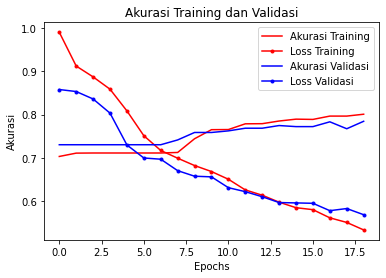

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
akurasi = history.history['accuracy']
val_akurasi = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(akurasi))

plt.plot(epochs, akurasi, 'r', label='Akurasi Training')
plt.plot(epochs, loss, 'r', marker='.', label='Loss Training')
plt.plot(epochs, val_akurasi, 'b', label='Akurasi Validasi')
plt.plot(epochs, val_loss, 'b', marker='.', label='Loss Validasi')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.title('Akurasi Training dan Validasi')
plt.legend()
plt.figure()

plt.show()

Nama : Tomi Nurhidayat

E-mail : tomi.nurhidayat933@gmail.com